In [9]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns



In [10]:
#import data
df = pd.read_csv('data/Recidivism_Data_cleaned.csv')
df_original = df.copy()

In [11]:
# We only want to predict recidivism within 3 years
#We are also looking at just Males
df.drop(['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3', 'Gender'], axis=1, inplace=True)

# Remove variables thaat are determined only after prison release
#df.drop(['Supervision_Risk_Score_First', 'Supervision_Level_First',
#         'Violations_ElectronicMonitoring', 'Violations_FailToReport','Violations_FailToReport', 'Violations_MoveWithoutPermission',
#         'Delinquency_Reports', 'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes', 
#         'DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive','DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 
#         'Percent_Days_Employed', 'Jobs_Per_Year', 'Employment_Exempt'], axis=1, inplace=True)

### Data Preprocessing

In [12]:
#Chance all Booleans to Integers
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

# Dummy Variable for Race 
df['Race'] = df['Race'].map({'BLACK': 1, 'WHITE': 0})

# Change age to integer as opposed to float
df['Age_at_Release'] = df['Age_at_Release'].astype(int)


In [13]:
df.dtypes

Race                                                   int64
Age_at_Release                                         int64
Residence_PUMA                                         int64
Gang_Affiliated                                        int64
Supervision_Risk_Score_First                         float64
Supervision_Level_First                               object
Education_Level                                       object
Dependents                                             int64
Prison_Offense                                        object
Prison_Years                                           int64
Prior_Arrest_Episodes_Felony                           int64
Prior_Arrest_Episodes_Misd                             int64
Prior_Arrest_Episodes_Violent                          int64
Prior_Arrest_Episodes_Property                         int64
Prior_Arrest_Episodes_Drug                             int64
Prior_Arrest_Episodes_PPViolationCharges               int64
Prior_Arrest_Episodes_DV

In [14]:
# Interger Encoded to for embeddings in NN
df['Prison_Offense'] = df['Prison_Offense'].map({category: idx for idx, category in enumerate(df['Prison_Offense'].unique())})
df['Education_Level'] = df['Education_Level'].map({'Less than HS diploma': 0, 'High School Diploma': 1, 'At least some college': 2})
df['Supervision_Level_First'] = df['Supervision_Level_First'].map({'Standard': 0, 'High': 1, 'Specialized': 2})

In [15]:
# Make Recidivism_Within_3years the last column
cols = [col for col in df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
df = df[cols]

In [16]:
# Variables to normalize
columns_to_normalize = ['Age_at_Release', 'Prison_Years', 'Supervision_Risk_Score_First', 'Percent_Days_Employed', 'Jobs_Per_Year']  # add other columns here

# Apply Standardization
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


In [17]:
#Split Train and Test Data
train_df = df[df['Training_Sample'] == 1]
test_df = df[df['Training_Sample'] == 0]
train_df = train_df.drop(columns=['Training_Sample'])
test_df = test_df.drop(columns=['Training_Sample'])

In [10]:
#X = train_df.drop('Recidivism_Within_3years', axis=1)
#y = train_df['Recidivism_Within_3years']

#X_test = test_df.drop('Recidivism_Within_3years', axis=1)
#y_test = test_df['Recidivism_Within_3years']

# Normalize continuous features (if necessary)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)


In [18]:
df.columns

Index(['Race', 'Age_at_Release', 'Residence_PUMA', 'Gang_Affiliated',
       'Supervision_Risk_Score_First', 'Supervision_Level_First',
       'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years',
       'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
       'Condition_Oth

### MLP

In [19]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [20]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): source data
        """
        # Assuming the last column is the label
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Convert features and labels to tensors
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label


In [21]:
#Convert pd dataframe to torch dataset
train_dataset = DataFrameDataset(train_df)
test_dataset = DataFrameDataset(train_df)

# use 15% of training data for validation
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
total_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [37]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Create fully connected layers (nn.Linear)
        ### START CODE ###
        self.fc1 = nn.Linear(47, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        ### END CODE ###

    def forward(self, x):
        ### START CODE ###
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ### END CODE ###
        return x


In [38]:
model = MLP()
# Create the optimizer
### START CODE ###
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
### END CODE ###

In [39]:
# Create the loss function instance
criterion = torch.nn.BCEWithLogitsLoss()

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Use the optimizer to perform backpropagation
        ### START CODE ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END CODE ###

        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    return avg_loss

@torch.no_grad()
def eval(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Get model's prediction
        ### START CODE ###
        pred = torch.sigmoid(out) >= 0.5
        ### END CODE ###

        # Count number of correct predictions
        ### START CODE ###
        correct = (pred.float() == target.float()).sum().item()
        ### END CODE ###

        total_correct += correct
        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    acc = total_correct / total_num
    return avg_loss, acc


In [40]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer)
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

100%|██████████| 10/10 [00:00<00:00, 491.47it/s]


Epoch: 1 Train Loss: 0.642128922274198 Val Loss: 0.6010701239209553 Val Acc: 0.6859190556492412


100%|██████████| 10/10 [00:00<00:00, 254.78it/s]


Epoch: 2 Train Loss: 0.5874465268738116 Val Loss: 0.5652638913005038 Val Acc: 0.7095278246205734


100%|██████████| 10/10 [00:00<00:00, 443.13it/s]


Epoch: 3 Train Loss: 0.566139085239239 Val Loss: 0.5521509763965318 Val Acc: 0.7221753794266442


100%|██████████| 10/10 [00:00<00:00, 265.97it/s]


Epoch: 4 Train Loss: 0.5578237975120047 Val Loss: 0.5481150324187833 Val Acc: 0.7280775716694773


100%|██████████| 10/10 [00:00<00:00, 322.93it/s]


Epoch: 5 Train Loss: 0.5521821093946014 Val Loss: 0.5441371790474221 Val Acc: 0.7276559865092749


100%|██████████| 10/10 [00:00<00:00, 475.97it/s]


Epoch: 6 Train Loss: 0.549409640488219 Val Loss: 0.5421208217614417 Val Acc: 0.7234401349072512


100%|██████████| 10/10 [00:00<00:00, 273.33it/s]


Epoch: 7 Train Loss: 0.5477677937978186 Val Loss: 0.5383169521368776 Val Acc: 0.7318718381112985


100%|██████████| 10/10 [00:00<00:00, 459.30it/s]


Epoch: 8 Train Loss: 0.5449599915471883 Val Loss: 0.5468834241566328 Val Acc: 0.7272344013490725


100%|██████████| 10/10 [00:00<00:00, 446.99it/s]


Epoch: 9 Train Loss: 0.542896078109067 Val Loss: 0.5442539621364407 Val Acc: 0.7192242833052277


100%|██████████| 10/10 [00:00<00:00, 295.24it/s]


Epoch: 10 Train Loss: 0.5394677936418735 Val Loss: 0.5382111884691261 Val Acc: 0.7322934232715008


100%|██████████| 10/10 [00:00<00:00, 210.64it/s]


Epoch: 11 Train Loss: 0.5361201266543799 Val Loss: 0.5357669626078356 Val Acc: 0.7344013490725126


100%|██████████| 10/10 [00:00<00:00, 432.43it/s]


Epoch: 12 Train Loss: 0.53394274312574 Val Loss: 0.5328686308699957 Val Acc: 0.734822934232715


100%|██████████| 10/10 [00:00<00:00, 485.06it/s]


Epoch: 13 Train Loss: 0.5317982934008966 Val Loss: 0.5350400417490311 Val Acc: 0.725548060708263


100%|██████████| 10/10 [00:00<00:00, 485.77it/s]


Epoch: 14 Train Loss: 0.5308723770726764 Val Loss: 0.5335766327320826 Val Acc: 0.7247048903878583


100%|██████████| 10/10 [00:00<00:00, 188.30it/s]

Epoch: 15 Train Loss: 0.5273309479477204 Val Loss: 0.5343082749220412 Val Acc: 0.7284991568296796


In [41]:
@torch.no_grad()
def test_accuracy(model, loader):
    model.eval()
    total_correct = 0
    total_num = 0
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out) >= 0.5
        correct = (pred.float() == target.unsqueeze(1).float()).sum().item()

        total_correct += correct
        total_num += len(target)

        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    acc = total_correct / total_num
    return acc, all_preds, all_targets

test_acc, all_preds, all_targets = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Test Accuracy: 74.01%


In [42]:
@torch.no_grad()
def test_accuracy(model, loader):
    model.eval()
    total_correct = 0
    total_num = 0
    all_preds = []
    all_targets = []
    all_probs = []  # To store probability estimates

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out) >= 0.5
        correct = (pred.float() == target.unsqueeze(1).float()).sum().item()

        total_correct += correct
        total_num += len(target)

        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(torch.sigmoid(out).cpu().numpy())  # Store probability estimates

    acc = total_correct / total_num
    return acc, all_preds, all_targets, all_probs  # Return probability estimates


In [ ]:
@torch.no_grad()
def test_roc_auc(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out)
        
        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

In [48]:
from sklearn.metrics import brier_score_loss

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

# Calculate the Brier Score using probability estimates
test_acc, _, _, all_probs = test_accuracy(model, test_loader)
brier_score = brier_score_loss(all_targets, all_probs)
print(f"Brier Score on Test Set: {brier_score:.4f}")

ROC AUC Score on Test Set: 0.8271
Brier Score on Test Set: 0.1645


In [44]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, total_train_loader, optimizer)  # Use total_train_loader
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

# After training, evaluate on the test set
test_acc, all_preds, all_targets = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


100%|██████████| 10/10 [00:00<00:00, 422.14it/s]


Epoch: 1 Train Loss: 0.5267751946876627 Val Loss: 0.5285633766228995 Val Acc: 0.7365092748735245


100%|██████████| 10/10 [00:00<00:00, 394.37it/s]


Epoch: 2 Train Loss: 0.5249510515490894 Val Loss: 0.523042762560949 Val Acc: 0.7377740303541316


100%|██████████| 10/10 [00:00<00:00, 429.28it/s]


Epoch: 3 Train Loss: 0.5204986320124896 Val Loss: 0.5293144788750107 Val Acc: 0.7360876897133221


100%|██████████| 10/10 [00:00<00:00, 444.86it/s]


Epoch: 4 Train Loss: 0.5200715792954936 Val Loss: 0.5197384436858243 Val Acc: 0.7440978077571669


100%|██████████| 10/10 [00:00<00:00, 213.47it/s]


Epoch: 5 Train Loss: 0.5189504753585016 Val Loss: 0.5181113383018147 Val Acc: 0.7403035413153457


100%|██████████| 10/10 [00:00<00:00, 395.49it/s]


Epoch: 6 Train Loss: 0.5172651898407798 Val Loss: 0.5260467274997126 Val Acc: 0.7352445193929174


100%|██████████| 10/10 [00:00<00:00, 253.34it/s]


Epoch: 7 Train Loss: 0.5149892456681111 Val Loss: 0.5133234401175385 Val Acc: 0.7474704890387859


100%|██████████| 10/10 [00:00<00:00, 442.55it/s]


Epoch: 8 Train Loss: 0.5129594669819452 Val Loss: 0.5143380505841659 Val Acc: 0.7432546374367622


100%|██████████| 10/10 [00:00<00:00, 490.41it/s]


Epoch: 9 Train Loss: 0.5138696606486732 Val Loss: 0.5117712165613801 Val Acc: 0.7470489038785835


100%|██████████| 10/10 [00:00<00:00, 461.13it/s]


Epoch: 10 Train Loss: 0.5105332222030704 Val Loss: 0.5135679810384876 Val Acc: 0.7474704890387859


100%|██████████| 10/10 [00:00<00:00, 484.05it/s]


Epoch: 11 Train Loss: 0.5092018951249149 Val Loss: 0.5080550390391486 Val Acc: 0.7478920741989882


100%|██████████| 10/10 [00:00<00:00, 444.94it/s]


Epoch: 12 Train Loss: 0.5058969749414252 Val Loss: 0.5076657722108883 Val Acc: 0.7470489038785835


100%|██████████| 10/10 [00:00<00:00, 270.20it/s]


Epoch: 13 Train Loss: 0.5057489110116722 Val Loss: 0.5064780864908562 Val Acc: 0.7445193929173693


100%|██████████| 10/10 [00:00<00:00, 390.64it/s]


Epoch: 14 Train Loss: 0.5057778060492796 Val Loss: 0.5084787411191211 Val Acc: 0.7440978077571669


100%|██████████| 10/10 [00:00<00:00, 462.53it/s]


Epoch: 15 Train Loss: 0.5032025126897137 Val Loss: 0.5045866444078706 Val Acc: 0.7478920741989882


ValueError: too many values to unpack (expected 3)

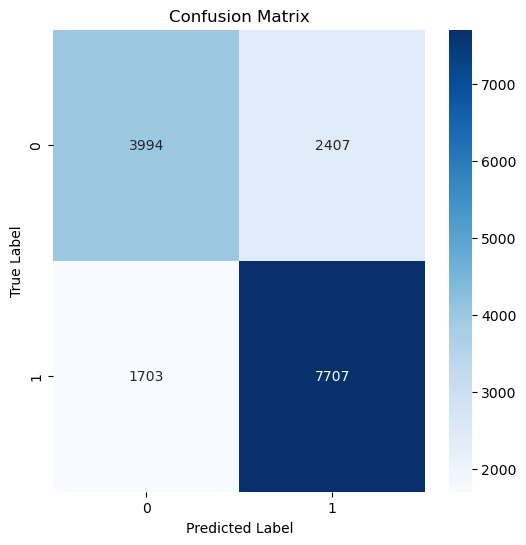

In [45]:
# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [47]:
@torch.no_grad()
def test_roc_auc(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out)
        
        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

ROC AUC Score on Test Set: 0.8271
